# Import Necessary Libraries

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import random

import math
from time import sleep
import cv2

import matplotlib.patches as patches

from google.colab.patches import cv2_imshow
from moviepy.editor import ImageSequenceClip

from google.colab.patches import cv2_imshow


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from tqdm import tqdm

  if event.key is 'enter':



In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Arm Class

In [ ]:
class Arm():
  def __init__(self, dof, arm_lengths = None):
    self.dof = dof

    if arm_lengths is None:
      self.arm_lengths = np.array([1.0 for x in range(dof)])
    else:
      assert len(arm_lengths) == dof, "Arm Lengths Array Must Have Same Length"
      self.arm_lengths = np.array(arm_lengths)

    self.states = np.array([0.0]*dof)

  def get_states(self):
    return self.states
  def set_states(self, states):
    assert len(states) == self.dof
    self.states = np.array(states)


  def step(self, thetas):
    assert len(thetas) == self.dof, f"thetas length must be same as dof: {len(thetas)} vs {self.dof}"
    self.states += thetas

  def get_end_positions(self):
    converted_thetas = self.states/180*math.pi
    x_deltas = np.cos(converted_thetas)*self.arm_lengths
    y_deltas = np.sin(converted_thetas)*self.arm_lengths
    end_positions = [(x_deltas[:idx+1].sum(), y_deltas[:idx+1].sum()) for idx in range(self.dof)]
    return np.array(end_positions)

  def draw_arm(self, resolution=512):

    width = int(sum(self.arm_lengths))*2
    end_positions = self.get_end_positions()/width*resolution + resolution//2
    image = np.zeros((resolution, resolution, 3), np.uint8)

    prev_x, prev_y = (resolution//2, resolution//2)
    for idx, (x, y) in enumerate(end_positions):
      y = resolution-y
      cv2.line(image, (prev_x, prev_y), (int(x), int(y)), (255, 255, 255))

      cv2.circle(image, (int(x), int(y)), 0, (255, 0, 0) if idx != self.dof - 1 else (0, 255, 0), 5)
      prev_x, prev_y = int(x), int(y)

    return image

# Designing Arm Simulation

## Physics

In [ ]:
class ArmPhysicsHandler():
  def __init__(self, dof, a_clamps = [-4500, 4500]):
    self.a_clamps = np.array(a_clamps) / 180 * math.pi

    self.previous_energy = None
    self.previous_position = None

    self.current_velocity = np.array([0.0 for x in range(dof)])
    self.energies = []
    self.kinetic_energies = []
    self.potential_energies = []
    self.velocities = []
    self.accelerations = []



  # Returns theta's, desaturated and physics constants added
  # TODO: Make this actually account for clipping rather than just clip the final velocity
  def verlet_step(self, arm, accel_applied, time_sec):
    environment_acceleration = self.get_environment_acceleration(arm.get_end_positions())
    acceleration = environment_acceleration + np.clip(accel_applied, self.a_clamps[0], self.a_clamps[1])

    if self.previous_position is None:
      self.previous_position = arm.get_states()

    current_position = arm.get_states()

    next_position = current_position + self.current_velocity * time_sec + 0.5 * acceleration * time_sec * time_sec
    arm.step(next_position - current_position)

    next_acceleration = self.get_environment_acceleration(arm.get_end_positions()) + np.clip(accel_applied, self.a_clamps[0], self.a_clamps[1])
    self.current_velocity += 0.5 * (acceleration + next_acceleration) * time_sec



    self.previous_position = current_position
    self.calculate_energy(self.current_velocity, arm.get_end_positions(), arm.arm_lengths, log = True, acceleration = acceleration)


  def step(self, arm, accel_applied, time_sec):

    environment_acceleration = self.get_environment_acceleration(arm.get_end_positions())
    environment_velocity = self.current_velocity + environment_acceleration*time_sec

    # This seeks to limit the energy of the system in the next time step, obviously not including the applied acceleration
    environment_velocity = self.energy_clip(arm, environment_velocity, time_sec)

    final_velocity = environment_velocity + np.clip(accel_applied, self.a_clamps[0], self.a_clamps[1])*time_sec

    # Takes into account how the final acceleration at the timestep should be averaged with the previous to get the average velocity
    average_velocity = (final_velocity+self.current_velocity) / 2

    thetas = average_velocity * time_sec / math.pi * 180
    self.current_velocity = final_velocity

    arm.step(thetas)

    self.calculate_energy(self.current_velocity, arm.get_end_positions(), arm.arm_lengths, log = True)


  def energy_clip(self, arm, velocities, time_sec):
    # Temporarily moving the arm by the environment velocity so as to register the converted potential energy
    average_velocity = (velocities+self.current_velocity) / 2

    thetas = average_velocity * time_sec / math.pi * 180
    arm.step(thetas)
    end_positions = arm.get_end_positions()
    arm_lengths = arm.arm_lengths
    arm.step(-thetas)


    moment_of_inertia = self.get_moment_of_inertia(end_positions)

    ke_list, PE = self.calculate_energy(velocities, end_positions, arm_lengths, log = False)
    KE = ke_list.sum()

    if self.previous_energy is None:
        self.calculate_energy(self.current_velocity, arm.get_end_positions(), arm.arm_lengths, log = True)
    elif KE+PE > self.previous_energy:
      available_ke = abs(self.previous_energy - PE)
      proportional_ke = ke_list / KE

      reduced_ke = proportional_ke * available_ke
      negative_mask = velocities / np.abs(velocities)

      velocities = np.sqrt(reduced_ke / moment_of_inertia / 0.5) * negative_mask



    return velocities

  def calculate_energy(self, velocities, end_positions, arm_lengths, acceleration = None, log = False):
    moment_of_inertia = self.get_moment_of_inertia(end_positions)
    # Rotational Kinetic Energy
    ke_list = 0.5 * moment_of_inertia * velocities * velocities
    KE = ke_list.sum()

    # Potential Energy - bottom of image is y = 0
    com, weights = self.get_accumulated_center_of_masses(end_positions)
    h = com[0][1]
    # PE = mgh
    PE = weights[0]*9.8*h

    if log:
      self.energies.append(KE+PE)
      self.kinetic_energies.append(KE)
      self.potential_energies.append(PE)
      self.velocities.append(velocities.sum())
      self.accelerations.append(acceleration)
      self.previous_energy = KE+PE

    return ke_list, PE

  # Adjusts acceleration with physics
  def get_environment_acceleration(self, end_positions):
    return self.gravity_acceleration(end_positions)

  # gets the acceleration caused by gravity on each individual joint
  def gravity_acceleration(self, end_positions):
    weight_centers, weights = self.get_accumulated_center_of_masses(end_positions)
    moi = self.get_moment_of_inertia(end_positions)
    # torque = rxf
    gravity_vector = np.array([[0, x] for x in weights])*-9.8

    torque = np.cross(weight_centers, gravity_vector, axis = 1)
    # t = Ia, which means a = t/I
    angular_acceleration = torque/moi
    return angular_acceleration

  # gets the moment of inertia of each portion of the arm
  def get_moment_of_inertia(self, end_positions):
    moments_of_inertia = []
    center_of_masses, weights = self.get_accumulated_center_of_masses(end_positions)
    r = np.linalg.norm(center_of_masses, axis = 1)
    # I = mr^2
    moi = weights*r*r
    return moi

  # Here we assume the arm's weight is evenly distributed at 1m = 1kg
  def get_accumulated_center_of_masses(self, end_positions):
    adjusted_end_positions = np.array([[0, 0]] + end_positions.tolist())
    center_of_masses = []
    weights = []
    for idx in range(len(adjusted_end_positions) - 1):
      midpoint = (adjusted_end_positions[idx] + adjusted_end_positions[idx+1]) / 2
      distance = np.linalg.norm(adjusted_end_positions[idx]-adjusted_end_positions[idx+1])

      center_of_masses.append(midpoint)
      weights.append(distance)


    center_of_masses = np.array(center_of_masses)
    weights = np.array(weights)

    masses, weights = self.accumulate_com(center_of_masses, weights)
    masses = masses - adjusted_end_positions[:-1]
    return masses, weights


  # Accumulate and Average a nx2 array
  def accumulate_com(self, center_of_masses, weights):
    accumulated_positions = []
    accumulated_weights = []
    for x in range(center_of_masses.shape[0]):
      # New Center of Mass
      weighted_positions = center_of_masses[x:].transpose((1, 0))*weights[x:]
      weighted_average_position = weighted_positions.sum(1) / weights[x:].sum()

      accumulated_weights.append(weights[x:].sum())
      accumulated_positions.append(weighted_average_position)

    return np.array(accumulated_positions), np.array(accumulated_weights)



In [ ]:

arm = Arm(2) #np.random.randint(1, 10, 2))
#arm.step(np.array([70,70, 70, 70, 70]))

arm_physics = ArmPhysicsHandler(arm.dof)

clips = []
for x in tqdm(range(1500)):
  arm_physics.verlet_step(arm, np.zeros(arm.dof), 1/60)
  clips.append(arm.draw_arm())


clips = ImageSequenceClip(clips, fps = 120)
clips.ipython_display(width = 360, maxduration = 1000000000)


100%|██████████| 1500/1500 [00:07<00:00, 205.96it/s]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


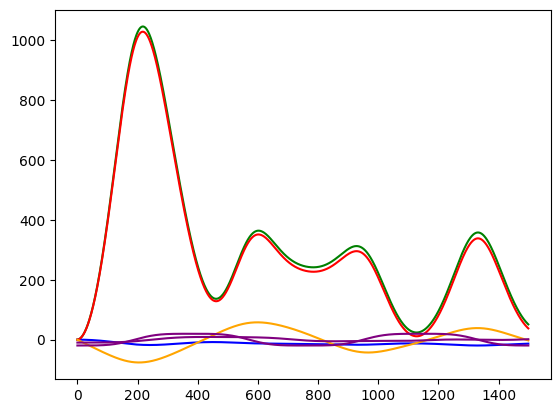

In [ ]:
plt.plot(arm_physics.kinetic_energies, c="green")
plt.plot(arm_physics.potential_energies, c = "blue")
plt.plot(arm_physics.energies, c = "red")
plt.plot(arm_physics.velocities, c = "orange")
plt.plot(arm_physics.accelerations, c = "purple")

## Designing a Round

In [ ]:
class ArmState():
  def __init__(self, arm: Arm, arm_physics: ArmPhysicsHandler, box_pos):
    self.arm_state = arm.get_states().copy()
    self.velocities = np.squeeze(arm_physics.current_velocity).copy()
    self.env_accel = arm_physics.get_environment_acceleration(arm.get_end_positions()).copy()
    self.box_pos = box_pos
    self.dof = arm.dof
  def get_input(self):
      return np.concatenate(
        (
            self.arm_state,
            self.velocities,
            self.box_pos,
            self.env_accel
        )
      )

class GameResult():
  def __init__(self, states, actions, rewards, losses, dof, box_pos, tolerance, timestep):
    self.states = states
    self.actions = actions
    self.rewards = rewards
    self.losses = losses
    self.dof = dof
    self.box_pos = box_pos
    self.tolerance = tolerance
    self.timestep = timestep

  def render_clip(self):
    clips = []
    for state in self.states:
      arm = Arm(self.dof)
      arm.set_states(state.arm_state)

      image = arm.draw_arm()


      width = self.dof * 2
      resolution = image.shape[0]
      # Scaling the box position to coordinates on an image
      box_coord = self.box_pos/width*resolution+resolution//2
      # Because +y is down, we subtract it from the resolution to get the flipped position
      box_coord[1] = resolution-box_coord[1]

      box_coord = box_coord.astype(np.int64)
      cv2.circle(image, box_coord, int(self.tolerance*resolution/width), (0, 0, 255), 2)

      clips.append(np.array(image, copy = True))


    return ImageSequenceClip(clips, fps = 1/self.timestep)





class GameRound():
  def __init__(self, dof, max_steps = 500, tolerance = 0.2, time_step = 1/30):
    self.dof = dof
    self.arm = Arm(dof)
    self.arm_physics = ArmPhysicsHandler(dof)
    self.max_steps = max_steps
    self.time_step = time_step
    self.current_steps = 0

    self.tolerance = tolerance


    self.states = []
    self.actions = []
    self.rewards = []
    self.losses = []

    self.box_pos = np.array(self.generate_box())
    self.box_pos = np.array([0, -2])

    self.arm.step(np.random.randint(0, 360, dof))


  def generate_box(self):
    x = np.random.random()*self.arm.arm_lengths.sum()
    y = np.random.random()*math.sqrt(self.arm.arm_lengths.sum()**2 - x**2)*np.random.randint(-1, 2)
    return x, y

  def render_box(self, image):
    width = self.arm.arm_lengths.sum() * 2
    resolution = image.shape[0]
    # Scaling the box position to coordinates on an image
    box_coord = self.box_pos/width*resolution+resolution//2
    # Because +y is down, we subtract it from the resolution to get the flipped position
    box_coord[1] = resolution-box_coord[1]

    box_coord = box_coord.astype(np.int64)
    cv2.circle(image, box_coord, int(self.tolerance*resolution/width), (0, 0, 255), 2)
    return image

  def step(self, model):
    state = ArmState(self.arm, self.arm_physics, self.box_pos)
    action = model(state.get_input())*self.arm_physics.a_clamps[1]
    self.arm_physics.step(self.arm, action.detach().numpy(), self.time_step)

    # target = torch.tensor(self.box_pos).to(DEVICE)
    # reward = torch.linalg.norm(target - x)
    reward = np.linalg.norm(self.box_pos - self.arm.get_end_positions()[-1])

    self.states.append(state)
    self.actions.append(action)
    self.rewards.append(reward)
    self.losses.append(-reward)
    self.current_steps += 1

    image = self.arm.draw_arm()
    return action, reward, self.render_box(image)

  def is_finished(self):
    return self.current_steps == self.max_steps or np.linalg.norm(self.box_pos - self.arm.get_end_positions()[-1])<=self.tolerance

  def get_result(self):
    return GameResult(self.states, self.actions, self.rewards, self.losses, self.dof, self.box_pos, self.tolerance, self.time_step)

In [ ]:

round = GameRound(3)
while not round.is_finished():
  round.step(lambda state: torch.zeros(3))[-1]
  #print(ArmState(round.arm, round.arm_physics, round.box_pos).get_input().shape)

round.get_result().render_clip().ipython_display(width = 360, maxduration = 1000000000)



Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
